## Alpaca Automated Stock Trading

> Moving strategy from R to the native python API client

### Strategy Parameters
1. N_DAYS_AGO
    - How many days of historical data to pull each run
2. OLS_Window
    - Rolling window for alpha / beta (intercept / slope) linear fit to general market movement

In [6]:
## Warning Handling
import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in double_scalars")
warnings.filterwarnings("ignore", message="Mean of empty slice.")
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")
warnings.filterwarnings("ignore", message="divide by zero encountered in log")

In [8]:
## API Library Setup
import os

## Robinhood API Setup
import robin_stocks as rs
# Connecting to RobinHood
rs.login(
    username = os.getenv("RH_LOGIN"),
    password = os.getenv("RH_PASS"),
    expiresIn = 3600*8,
    by_sms = True
)

## Alpaca API Setup
import alpaca_trade_api as tradeapi
# Connecting to Alpaca
api = tradeapi.REST(os.getenv("AP_KEY"),os.getenv("AP_SECRET"), api_version='v2')

ERROR: There was an issue loading pickle file. Authentication may be expired - logging in normally.


Enter Robinhood code for validation:  550755


In [9]:
N_DAYS_AGO = 365
OLS_Window = 5
min_list_years = 5
min_volume = 400000
max_investment = 1180*0.2
min_investment = 15

In [10]:
%matplotlib inline
## Installing Required Packages
import sys
import time
import math
import pickle
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date, time
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy import stats

## Setting Project Folder
Project_Folder = "C://Users//" + os.getlogin() + "//documents//github//Stock-Strategy-Exploration//"

## Reading In Functions
Function_Files = os.listdir('Functions')
for File in Function_Files:
    if '.py' in File:
        print(File)
        Full_File = 'Functions/'+File
        exec(open(Full_File).read())
        
def years_listed(d1):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.today()
    return abs((d2 - d1).days/365)

Group_Consolidator.py
Stock_Consolidator.py
Technical_Indicators.py


### Historical Data Pull

In [11]:
## Pulling All Available Alpaca Symbols
assets = api.list_assets("active")
Final_Assets = [i._raw['symbol'] for i in assets \
                if i._raw['tradable'] \
                    & i._raw['shortable'] \
                    & i._raw['easy_to_borrow']]

## Pulling All Bar Data
s_inc = 100
print("Starting Initial Data Pull")
Splits = [0]
while Splits[len(Splits)-1] < (len(Final_Assets)-1):
    if Splits[len(Splits)-1] + s_inc > (len(Final_Assets)-1):
        Splits.append((len(Final_Assets)-1))
    else:
        Splits.append(Splits[len(Splits)-1] + s_inc)
Initial_Bars = {}
for i in tqdm(range(1,len(Splits))):
    Initial_Bars.update(api.get_barset(symbols = Final_Assets[Splits[i-1]:Splits[i]],
                                      timeframe = 'day',
                                      limit = N_DAYS_AGO))

print("Filtering Based On Average Price and Volume")
## Filtering Based On Price And Volume Criteria
Stocks = []
for i in tqdm(Final_Assets):
    try:
        Price_Data = Initial_Bars[i].df
        Price = np.mean(Price_Data['close'])
        Volume = np.mean(Price_Data['volume'])
        if Price < max_investment \
        and Price > min_investment \
        and i in Final_Assets \
        and Volume > min_volume:
            Stocks.append(i)
    except:
        print("Skipped",i,"No Data")

print("Pulling Company Data")
## Pulling Polygon Company Data
Splits = [0]
while Splits[len(Splits)-1] < (len(Stocks)-1):
    if Splits[len(Splits)-1] + 50 > (len(Stocks)-1):
        Splits.append((len(Stocks)-1))
    else:
        Splits.append(Splits[len(Splits)-1] + 50)
Company_Data = {}
for i in tqdm(range(1,len(Splits))):
    Company_Data.update(api.polygon.company(Stocks[Splits[i-1]:Splits[i]]))

## Filtering Based on Company Information
Updated_Stocks = list(Company_Data.keys())
Final_Stocks = []
for i in Updated_Stocks:
    if not Company_Data[i].active:
        continue
    if years_listed(Company_Data[i].listdate) > min_list_years:
        Final_Stocks.append(i)
        
## Amount of Historical Data to Pull
start_date = datetime.now() - timedelta(days=N_DAYS_AGO)
Historical_Data = defaultdict(pd.DataFrame)

print("Formatting Final Dataset")
## Formatting Final Dataset
counter = 0
for i in tqdm(Final_Stocks):
    TMP = Initial_Bars[i].df
    TMP['date'] = TMP.index
    TMP['sector'] = Company_Data[i].sector
    TMP['industry'] = Company_Data[i].industry
    Historical_Data[i] = TMP 

## Adding Ticker Column
for s in Historical_Data:
    Historical_Data[s].insert(0, 'stock', [s]*len(Historical_Data[s]))

## Combining Data To Single Data Frame
Combined_Data = pd.concat(Historical_Data.values())  
Combined_Data = Combined_Data[Combined_Data['sector'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['sector'])]
Combined_Data = Combined_Data[Combined_Data['industry'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['industry'])]

## Saving Data
pickle.dump(Combined_Data, open(Project_Folder + "Data//Historical_Data.p" , "wb" ) )

Starting Initial Data Pull



Filtering Based On Average Price and Volume


Skipped BHP No Data

Pulling Company Data



Formatting Final Dataset


### Exploring Total Market Performance

In [12]:
## Loading Stored Data
Combined_Data = pickle.load(open(Project_Folder + "Data//Historical_Data.p" , "rb" ))
Combined_Data = Combined_Data.drop_duplicates()
Combined_Data = Combined_Data[(datetime.now() - timedelta(days = N_DAYS_AGO)).strftime("%Y-%m-%d"):datetime.now().strftime("%Y-%m-%d")]

Total_Market = Stock_Consolidator(Combined_Data)
Total_Market = Total_Market.loc[Total_Market.RSI > 0,:]
Total_Market.tail(10)

,close,high,low,volume,count,close_diff,close_return,volume_diff,sma,RSI,MACD
date,,,,,,,,,,,
2020-10-01 00:00:00-04:00,66.271495,67.122681,65.211541,3.233196e+06,1083.0,0.009130,0.043132,-0.012501,65.458176,40.237418,0.074593
2020-10-02 00:00:00-04:00,66.374403,67.224479,64.672167,3.009142e+06,1083.0,0.001553,0.030147,-0.069298,65.846664,42.836163,0.134543
2020-10-05 00:00:00-04:00,67.693819,68.187416,66.384777,2.809365e+06,1083.0,0.019878,0.031579,-0.066390,66.261111,36.972071,0.251149
2020-10-06 00:00:00-04:00,67.184850,69.002153,66.705255,3.232385e+06,1083.0,-0.007519,0.028960,0.150575,66.639295,42.733432,0.279898
2020-10-07 00:00:00-04:00,68.467143,69.154222,67.375470,2.828504e+06,1083.0,0.019086,0.042564,-0.124948,67.198342,45.988734,0.365748
2020-10-08 00:00:00-04:00,69.180997,69.850218,68.142347,2.974607e+06,1083.0,0.010426,0.043903,0.051654,67.780242,46.422056,0.445778
2020-10-09 00:00:00-04:00,69.640139,70.521360,68.830189,2.833941e+06,1082.0,0.006637,0.049202,-0.047289,68.433390,44.551576,0.500694
2020-10-12 00:00:00-04:00,69.958699,70.788455,69.097528,2.722821e+06,1083.0,0.004574,0.033458,-0.039210,68.886366,48.055877,0.526876
2020-10-13 00:00:00-04:00,69.562365,70.576593,68.787216,2.960785e+06,1083.0,-0.005665,0.035388,0.087396,69.361869,47.342203,0.486854


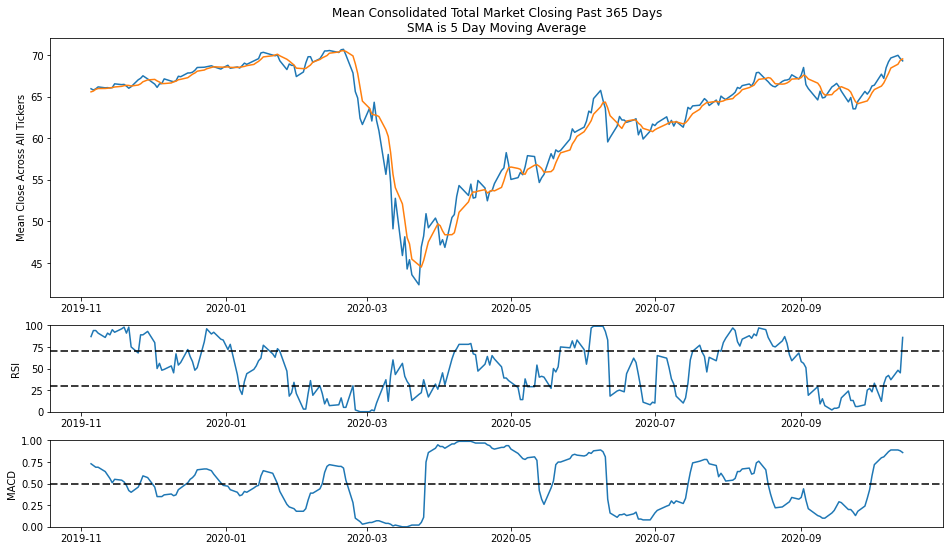

In [13]:
Plot_Data = Total_Market
Plot_Data['RSI'] = pd.qcut(Plot_Data.RSI,100,labels = False)
# Plot_Data['RSI'] = ((Plot_Data['RSI'] -  np.min(Plot_Data['RSI'])) / (np.max(Plot_Data['RSI']) - np.min(Plot_Data['RSI'])))*100
Plot_Data['MACD'] = pd.qcut(Plot_Data.MACD,100,labels = False)/100
# Plot_Data['MACD'] = (1 + 1)*((Plot_Data['MACD'] -  np.min(Plot_Data['MACD'])) / (np.max(Plot_Data['MACD']) - np.min(Plot_Data['MACD']))) - 1

Plot_Data['date'] = Plot_Data.index.get_level_values('date')
Plot_Data = Plot_Data.reset_index(drop = True)
x = Plot_Data['date']

fig, axs = plt.subplots(3,1,gridspec_kw={'height_ratios':[3,1,1]})
axs[0].plot(x,Plot_Data['close'])
axs[0].plot(x,Plot_Data['sma'])
axs[1].plot(x,Plot_Data['RSI'])
axs[1].axhline(y = 70,c = 'black',dashes = (5,2))
axs[1].axhline(y = 30,c = 'black',dashes = (5,2))
axs[2].plot(x,Plot_Data['MACD'])
axs[2].axhline(y = 0.50,c = 'black',dashes = (5,2))

axs[0].set(title = "Mean Consolidated Total Market Closing Past "+ str(N_DAYS_AGO) +" Days\nSMA is " + str(OLS_Window) +" Day Moving Average",
      ylabel = "Mean Close Across All Tickers",
      xlabel = "")
axs[1].set(ylabel = "RSI",
      xlabel = "",
      ylim = [0,100])
axs[2].set(
    ylabel = "MACD",
    xlabel = "",
    ylim = [0,1]
)
fig.set_size_inches(16,9)

In [14]:
## Calculating Market Deciders
Market_Strength = np.mean(Total_Market.RSI.tail(5))/100
Market_Momentum = (np.mean(Plot_Data.MACD.tail(5))-np.min(Plot_Data.MACD.tail(5)))/(np.max(Plot_Data['MACD'].tail(5)) - np.min(Plot_Data['MACD'].tail(5)))
print("Market Strength :",np.round(Market_Strength,3),
      "\nMarket_Momentum :",np.round(Market_Momentum,3))

Max_Beta_P = np.round(1 - Market_Momentum,3)
Min_Beta = 1 if Market_Momentum > 0.50 else -2
Max_Alpha_P = np.round(Market_Momentum,3)
Min_Alpha = 0 if Market_Momentum <= 0.50 else -1

print("Beta Significance :",Max_Beta_P,
     "\nAlpha Significance :",Max_Alpha_P)

Market Strength : 0.516 
Market_Momentum : 0.6
Beta Significance : 0.4 
Alpha Significance : 0.6


## Digging Into A Sector Ranking

In [28]:
Sectors = list(Combined_Data['sector'].unique())
Total_Sector_Summary = Group_Consolidator(
    Combined_Data = Combined_Data,
    groups = Sectors,
    column = 'sector'
)
Sector_Summary = Group_Consolidator(Combined_Data = Combined_Data,
                                    groups = Sectors,
                                    column = 'sector',
                                    min_macd = 0,
                                    max_beta_p = Max_Beta_P,
                                    max_alpha_p = Max_Alpha_P,
                                    min_beta = Min_Beta,
                                    min_alpha = Min_Alpha,
                                    max_rsi = 70,
                                    min_risk_ratio = 1
)
if len(Sector_Summary) != 0:
    Sector_Summary
else: 
    Sector_Summary = list()
    print("No Viable Sectors Currently")

No Viable Sectors Currently


## Diving Further Into Individual Idustries

In [30]:
if type(Sector_Summary) is not list:
    Top_Sector = Combined_Data[Combined_Data['sector'].isin(Sector_Summary.index.values)]
    Industries = list(Top_Sector['industry'].unique())
    Industry_Summary = Group_Consolidator(Combined_Data = Top_Sector,
                                          groups = Industries,
                                          column = 'industry',
                                          min_macd = 0,
                                          max_beta_p = Max_Beta_P,
                                          max_alpha_p = Max_Alpha_P,
                                          min_beta = Min_Beta,
                                          min_alpha = Min_Alpha,
                                          max_rsi = 70,
                                          min_risk_ratio = 1
                                         )
    Industry_Summary
else:
    print("No sectors to loop through")
    Industry_Summary = list()

No sectors to loop through


## Diving Into The Individual Stocks

In [31]:
if type(Industry_Summary) is not list:
    Top_Industry = Top_Sector[Top_Sector['industry'].isin(Industry_Summary.index.values)]
    Stocks = list(Top_Industry['stock'].unique())
    Stock_Summary = Group_Consolidator(Combined_Data = Top_Industry,
                                       groups = Stocks,
                                       column = 'stock',
                                       min_macd = 0,
                                       min_risk_ratio = 1,
                                       max_rsi = 50
    )
    Stock_Summary. \
        sort_values(by = ['rsi'],ascending = [1])
else:
    print("No industries to loop through")
    Stock_Summary = list()

No industries to loop through


In [34]:
## Pulling Current Stock Holdings
my_stocks = rs.build_holdings()
Current_Holdings = pd.DataFrame({key:value for key,value in my_stocks.items()})

## Combining Lists
Stocks = list(Current_Holdings.keys())
if len(Stock_Summary) != 0:
    Stocks.extend(list(Stock_Summary.index))
Stocks = list(set(Stocks))

## Pulling Historical Data
Stock_Data = pd.DataFrame()
for Stock in Stocks:
    Stock_Data[Stock] = Combined_Data['close'][Combined_Data.stock == Stock]
    
## Creating expected mean and variance matricies
mu = expected_returns.mean_historical_return(Stock_Data)#returns.mean() * 252
S = risk_models.sample_cov(Stock_Data) #Get the sample covariance matrix

## Optimizing Sharpe Ratio
ef = EfficientFrontier(
    expected_returns = mu,
    cov_matrix = S, 
    weight_bounds = (0,0.20),
    verbose = False
)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights() 

## Subsetting Stock Picks
Final_Picks = []
for stock in cleaned_weights.keys():
    if cleaned_weights[stock] > 0:
        print(stock," : ",cleaned_weights[stock])
        Final_Picks.append(stock)
        
Optimized_Portfolio = ef.portfolio_performance(verbose=True)

PEN  :  0.2
ABC  :  0.2
MCK  :  0.05578
BMRN  :  0.14422
KURA  :  0.2
DGX  :  0.2
Expected annual return: 43.3%
Annual volatility: 36.0%
Sharpe Ratio: 1.14


## Robinhood Automated Investing POC

In [38]:
## Pulling Relevent Account Information
Account_Equity = float(rs.build_user_profile()['equity'])
Buying_Power = float(rs.profiles.load_account_profile('buying_power'))

## Pulling Open Orders
Open_Orders = rs.orders.get_all_open_stock_orders()
# Appending Stock Symbols
for item in Open_Orders:
    item['symbol'] = rs.get_symbol_by_url(item['instrument'])

## Pulling Current Stock Holdings
my_stocks = rs.build_holdings()
Current_Holdings = pd.DataFrame({key:value for key,value in my_stocks.items()})
    
## Checking Portfolio Balancing And Placing New Orders
for s in Final_Picks:
    
    # Portfolio Restructuring
    if s in list(Current_Holdings.keys()):
        
        # Current Portfolio Percentage
        Pct_Holding = float(Current_Holdings[s].percentage)
        # Optimal Portfolio Percentage
        Rcm_Holding = cleaned_weights[s]*100
        
        # Rebalancing If Beyond Recommended Holding
        if Pct_Holding > Rcm_Holding:
            print("Rebalancing",s,": Currently =",Pct_Holding,", Target =",Rcm_Holding)
            
            # Canceling Any Open Orders
            if s in [item['symbol'] for item in Open_Orders]:
                Order_Ids = [item['id'] for item in Open_Orders if item['symbol'] == s]
                print("Canceling Existing Order:",Order_Id)
                for ID in Order_Ids:
                    rs.orders.cancel_stock_order(ID)
                    
            # Placing Sell Order
            Sell_Amount = float(Current_Holdings[s]['equity']) - Account_Equity*Rcm_Holding/100
            print("Selling ",np.round(Sell_Amount))
            Order_Info = rs.orders.order_sell_fractional_by_price(
                symbol = s,
                amountInDollars = Sell_Amount,
                timeInForce = 'gfd',
                extendedHours = False
            )
            print("Order ID:",Order_Info['id'],"placed")
        
        # Checking If More Needs Purchased
        elif Pct_Holding < Rcm_Holding*0.95:
            print("Rebalancing",s,": Currently =",Pct_Holding,", Target =",Rcm_Holding)
            
            # Canceling Any Open Orders
            if s in [item['symbol'] for item in Open_Orders]:
                Order_Ids = [item['id'] for item in Open_Orders if item['symbol'] == s]
                print("Canceling Existing Order:",Order_Id)
                for ID in Order_Ids:
                    rs.orders.cancel_stock_order(ID)
            
             # Placing Buy Order
            Buy_Amount = Account_Equity*Rcm_Holding/100 - float(Current_Holdings[s]['equity'])
            print("Buying ",np.round(Buy_Amount))
            
            if Buy_Amount <= Buying_Power and Buy_Amount > 1:
                Order_Info = rs.orders.order_buy_fractional_by_price(
                    symbol = s,
                    amountInDollars = Buy_Amount,
                    timeInForce = 'gfd',
                    extendedHours = False
                )
                Buying_Power = float(rs.profiles.load_account_profile('buying_power'))
                print("Order ID:",Order_Info['id'],"placed")
            else:
                if Buy_Amount < 1:
                    print("Buy Amount Less Than Minimum (1$) :",np.round(Buy_Amount))
                else:
                    print("Not Enough Buying Power")
        else:
            print(s," Within Recommended Percentage")

Found Additional pages.
Loading page 2 ...
Loading page 3 ...
Loading page 4 ...
Loading page 5 ...
Rebalancing PEN : Currently = 17.96 , Target = 20.0
Buying  32.0
Order ID: 94a6e35d-9b37-4b49-9ad7-39442ee1b58a placed
Rebalancing ABC : Currently = 17.18 , Target = 20.0
Buying  41.0
Order ID: 79f5b568-9c44-4744-b1a2-23b7af1e9df5 placed
Rebalancing MCK : Currently = 3.09 , Target = 5.578
Buying  31.0
Order ID: bfb37a06-9582-4062-8632-91fd436425e9 placed
BMRN  Within Recommended Percentage
Rebalancing KURA : Currently = 17.51 , Target = 20.0
Buying  37.0
Order ID: 6fdd23df-d94e-4903-8514-52e38ad6322e placed
Rebalancing DGX : Currently = 10.27 , Target = 20.0
Buying  120.0
Order ID: 123e9db0-5f91-4b61-be5e-14d36b6caa51 placed
